<p align= "center">
<img width="300" src="https://logos-world.net/wp-content/uploads/2020/11/GitHub-Emblem.png" alt="Github Logo">
</p>


<h1 align = "center">Programming Language Detection</h1>

<h2 align = "center">By Chloe Whitaker, Jeanette Schulz, Brian Clements, and Paige Guajardo </h2>
<h4 align = "center">11 February 2022</h4>



<hr style="border:2px solid blue"> </hr>

# About this Project
### Github Webscraping and Natural Language Processing
Millions of developers and companies build, ship, and maintain their software on GitHub— the largest and most advanced development platform in the world. As Codeup's new up-and-coming Data Scientists, we will be using GitHub's platform to practice both our Web-Scraping skills and our Natural Language Processing (NLP) skills. With a focus on repositories that are studying bitcoin, our goal is to predict the programming language used in a repository based solely on the README.md file provided. By exploring the text provided in the README, we hope to identify key words that will allow us to identify which programming language(s) were used. Then we will teach these to our classification model so that it will predict the programming language of any future repositories we show it. For our project, we focused on five most common languages from Bitcoin repositories and named the rest 'Other'. The list of languages we will try to predict are: 
- JavaScript         
- Python             
- C++                 
- PHP                 
- C                                   
- Java   
- Other

### Project Goal: 

The goal is to scrape README pages from BitCoin related repositories on GitHub, so that we can predict the language of that repository. 

### Project Desciption: 

Language Predictor. This is a group project where we will be scraping GitHub repository README files related to BitCoin. We will then produce a classification model that will be able to predict the programming language of that repository using only the text in the README. 


# Data Dictionary

| Feature                    | Datatype               | Description                                                           |
|:---------------------------|:-----------------------|:----------------------------------------------------------------------|
| repo                       | object  | github repo name             |
| language                       | object  | repo programming language            |
| readme_contents                       | object  | contents of the repo's readme             |


<hr style="border:2px solid blue"> </hr>

### Imports

Here are the imports needed to run this notebook.

In [1]:
import pandas as pd
import numpy as np

# Scraping
import requests
from bs4 import BeautifulSoup

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
import nltk.sentiment

from wordcloud import WordCloud
# pd.set_option('display.max_colwidth', -1)

# Regex
import re

# Time
from time import strftime

import unicodedata
import json
from pprint import pprint

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Custom Imports
# import acquire 
import prepare
import wrangle
import model
# Turn off pink boxes for demo
import warnings
warnings.filterwarnings("ignore")

--------

# Let's Get Started...

-----

## Wrangle

Use the wrangle.py helper file to acquire and prepare the GitHub README data. 

In [2]:
# df=acquire.make_json(cached=True)
df = pd.read_json('repo_readmes.json')

In [3]:
df.head()

,repo,language,readme_contents
0,bitcoin/bitcoin,C++,Bitcoin Core integration/staging tree\n=======...
1,bitcoinbook/bitcoinbook,AsciiDoc,Code Examples: ![travis_ci](https://travis-ci....
2,bitcoinj/bitcoinj,Java,[![Github Build Status](https://github.com/bit...
3,bitcoin/bips,Wikitext,"People wishing to submit BIPs, first should pr..."
4,bitcoinjs/bitcoinjs-lib,TypeScript,# BitcoinJS (bitcoinjs-lib)\n[![Github CI](htt...


In [4]:
df.shape

(80, 3)

In [5]:
# Save the names of the top 5 programming languages, and change the rest to 'Other'
df['language'] = df.language.apply(wrangle.common_language)

In [6]:
df = wrangle.brian_quick_clean(df)

In [7]:
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = \
wrangle.split_repos(df)

### Steps Taken to Prepare the Data:

## Exploration

### Initial Hypotheses/Questions:

#### Initial Hypothesis: 

A lot of the repository READMEs probably contain the name of the language that the repo is in. 

#### Initial Questions: 
    1. What are the most frequently occuring words in the readmes?
    2. Are there words that uniquely identify with a certain language's repos?
    3. 
    4. Do most README's have the word of the programming language used?

### Explore: 

To further prepare the data for explore, I will combine all of the words from the readmes together so that I can explore the entire word set as well as by language. I will also remove the common stop words and represent the contents as word frequencies.

In [8]:
# combine all contents in single string by language

javascript_words = (' '.join(train[train.language == 'JavaScript'].lemmatized))
c_plus_plus__words = (' '.join(train[train.language == 'C++'].lemmatized))
c_words = (' '.join(train[train.language == 'C'].lemmatized))
python_words = (' '.join(train[train.language == 'Python'].lemmatized))
php_words = (' '.join(train[train.language == 'PHP'].lemmatized))
java_words = (' '.join(train[train.language == 'Java'].lemmatized))
other_words = (' '.join(train[train.language == 'Other'].lemmatized))
all_words = (' '.join(train.lemmatized))

In [9]:
# remove_stopwords

javascript_words = wrangle.remove_stopwords(str(javascript_words))
c_plus_plus__words = wrangle.remove_stopwords(str(c_plus_plus__words))
c_words = wrangle.remove_stopwords(str(c_words))
python_words = wrangle.remove_stopwords(str(python_words))
java_words = wrangle.remove_stopwords(str(java_words))
php_words = wrangle.remove_stopwords(str(php_words))
other_words = wrangle.remove_stopwords(str(other_words))
all_words = wrangle.remove_stopwords(str(all_words))

In [10]:
# represent contents as word frequencies

javascript_freq = pd.Series(javascript_words.split()).value_counts()
c_plus_plus_freq = pd.Series(c_plus_plus__words.split()).value_counts()
c_freq = pd.Series(c_words.split()).value_counts()
python_freq = pd.Series(python_words.split()).value_counts()
java_freq = pd.Series(java_words.split()).value_counts()
php_freq = pd.Series(php_words.split()).value_counts()
other_freq = pd.Series(other_words.split()).value_counts()
all_freq = pd.Series(all_words.split()).value_counts()

I will concatinate all of the word frequencies together into a dataframe. 

In [11]:
# concat all frequencies together into a dataframe

word_counts = pd.concat([javascript_freq, c_plus_plus_freq, c_freq, python_freq, java_freq, php_freq, other_freq, all_freq], axis=1).fillna(0).astype(int)
word_counts.columns = ['javascript', 'c_plus_plus', 'c', 'python', 'java', 'php', 'other', 'all']
# word_counts.head()

#### Question: What are the most frequently occuring words in the readmes?

In [12]:
# most frequently occuring words: sort by 'all'
word_counts.sort_values('all', ascending=False).head(20)

,javascript,c_plus_plus,c,python,java,php,other,all
bitcoin,13,9,14,15,27,14,65,157
transaction,14,3,12,1,98,1,28,157
&#9;,27,0,21,0,0,0,86,134
standard,1,0,0,6,0,0,123,130
use,9,5,6,16,27,3,35,101
stylebackgroundcolor,0,0,0,0,0,0,100,100
block,8,0,12,25,29,1,19,94
run,15,9,3,18,6,1,42,94
install,10,11,2,53,0,1,14,91
using,14,3,0,24,7,2,29,79


- Are there words that uniquely identify with a certain language's repos?

JavaScript contain the highest precentage of the 20 most common words used in the readmes. 

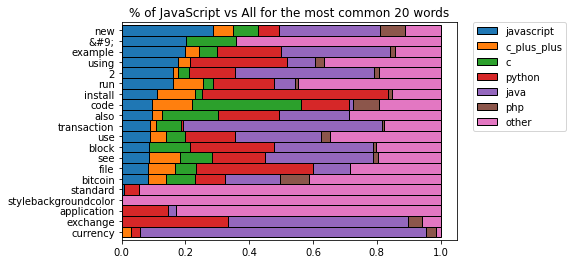

In [13]:
(word_counts.sort_values('all', ascending=False)
 .head(20)
 .apply(lambda row: row/row['all'], axis = 1)
 .drop(columns = 'all')
 .sort_values(by = 'javascript')
 .plot.barh(stacked = True, width = 1, ec = 'k')
)
plt.title('% of JavaScript vs All for the most common 20 words')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0);

The most common words by language: 

In [14]:
javascript_freq.idxmax(), java_freq.idxmax(), c_plus_plus_freq.idxmax(), c_freq.idxmax(), python_freq.idxmax(), java_freq.idxmax(), php_freq.idxmax(), other_freq.idxmax(), all_freq.idxmax()



('client',
 'transaction',
 'window',
 'parser',
 'install',
 'transaction',
 'php',
 'standard',
 'bitcoin')

#### Question 2: What are the least frequently occuring words in the readmes?

In [15]:
# most frequently occuring words: sort by 'all'
word_counts.sort_values('all', ascending=False).tail(20)

,javascript,c_plus_plus,c,python,java,php,other,all
row,0,0,0,1,0,0,0,1
_cryptography,0,0,0,1,0,0,0,1
tgtvaluesi,0,0,0,1,0,0,0,1
34,0,0,0,1,0,0,0,1
pylab,0,0,0,1,0,0,0,1
bitcointradingalgorithmtoolkit,0,0,0,1,0,0,0,1
backtesting,0,0,0,1,0,0,0,1
equal,0,0,0,1,0,0,0,1
warm,0,0,0,1,0,0,0,1
ai,0,0,0,1,0,0,0,1


* We really dont see any key info lets see with a graph now

<Figure size 1440x720 with 0 Axes>

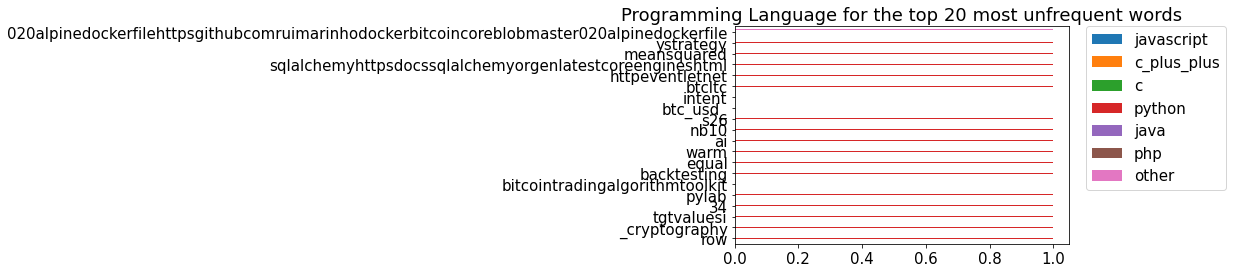

In [16]:
plt.figure(figsize=(20,10))
plt.rc('font', size=15)
word_counts.sort_values('all', ascending=False).tail(20)[['javascript',
'c_plus_plus',
'c',
'python',
'java',
'php',
'other'                                                    
]].plot.barh()
plt.title('Programming Language for the top 20 most unfrequent words')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0);

* Alot of these words seem to be tied with only C++, lets take a look finally at the bottom words of all the langauges!

In [17]:
javascript_freq.idxmin(), java_freq.idxmin(), c_plus_plus_freq.idxmin(), c_freq.idxmin(), python_freq.idxmin(), java_freq.idxmin(), php_freq.idxmin(), other_freq.idxmin(), all_freq.idxmin()


('contain',
 'm8900',
 'moment',
 'jump',
 'libtool',
 'm8900',
 'connectionobject',
 'text',
 'blkto_json')

#### Question 3: Does the length of the README vary by programming language?

In [120]:
length_list =df.groupby('language')\
.apply(lambda x: x.lemmatized.str.len().mean())
# .apply(lambda x: x/len(df[df.language]))

In [123]:
length_list

language
C             4606.000000
C++           2458.000000
Java          5192.500000
JavaScript    9333.000000
Other         5078.600000
PHP           1353.857143
Python        3097.384615
dtype: float64

In [126]:
i=0
for index in length_list.index:
    print(f"{index}'s average repo length is {length_list[i]/len(df[df.language==index])}")
    i+=1

C's average repo length is 1151.5
C++'s average repo length is 175.57142857142858
Java's average repo length is 649.0625
JavaScript's average repo length is 1037.0
Other's average repo length is 203.144
PHP's average repo length is 193.40816326530611
Python's average repo length is 238.26035502958578


- The language with the longest repos, by far, is C (using the current dataset)
- Outside of Java, the rest of the repos have an average length of roughly 200 or so lemmatized words

### Exploration Takeaways:

### Features to Move Forward with:

## Modeling

### Our best-performing model without undue overfitting was a Logistic Regression model

### We ran over 10 models, between a bag-of-words approach and a tf-idf approach

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score

## TF-IDF Method

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.lemmatized)
y = df.language

X_train, X_validate, y_train, y_validate = train_test_split(X, y, stratify=y, \
                                                            test_size=.2)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train,stratify=y_train, test_size=.2)

In [20]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
train = pd.DataFrame(dict(actual=y_train))
validate = pd.DataFrame(dict(actual=y_validate))

lm = LogisticRegression().fit(X_train, y_train)

train['lr_predicted_tdidf'] = lm.predict(X_train)
validate['lr_predicted_tdidf'] = lm.predict(X_validate)

### Confustion matrix, train data

In [21]:
model.print_lr_tfidf_model_train(train)

Accuracy: 66.67%
---
Confusion Matrix
actual              C  C++  Java  JavaScript  Other  PHP  Python
lr_predicted_tdidf                                              
C++                 0    9     0           0      0    0       0
Other               2    0     5           5     16    5       0
Python              0    0     0           0      0    0       9
---
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         2
         C++       1.00      1.00      1.00         9
        Java       0.00      0.00      0.00         5
  JavaScript       0.00      0.00      0.00         5
       Other       0.48      1.00      0.65        16
         PHP       0.00      0.00      0.00         5
      Python       1.00      1.00      1.00         9

    accuracy                           0.67        51
   macro avg       0.35      0.43      0.38        51
weighted avg       0.51      0.67      0.56        51



### Confustion matrix, validate data

In [22]:
model.print_lr_tfidf_model_validate(validate)

Accuracy: 31.25%
---
Confusion Matrix
actual              C  C++  Java  JavaScript  Other  PHP  Python
lr_predicted_tdidf                                              
Other               1    3     2           2      5    1       2
---
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         1
         C++       0.00      0.00      0.00         3
        Java       0.00      0.00      0.00         2
  JavaScript       0.00      0.00      0.00         2
       Other       0.31      1.00      0.48         5
         PHP       0.00      0.00      0.00         1
      Python       0.00      0.00      0.00         2

    accuracy                           0.31        16
   macro avg       0.04      0.14      0.07        16
weighted avg       0.10      0.31      0.15        16



## TF-IDF Method

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

In [24]:
tfidf = TfidfVectorizer()
X = vectorizer.fit_transform(df.lemmatized)
y = df.language

X_train, X_validate, y_train, y_validate = train_test_split(X, y, stratify=y, \
                                                            test_size=.2)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train,stratify=y_train, test_size=.2)

In [25]:
train = pd.DataFrame(dict(actual=y_train))
validate = pd.DataFrame(dict(actual=y_validate))

lm = LogisticRegression().fit(X_train, y_train)

train['lr_predicted_bagofwords'] = lm.predict(X_train)
validate['lr_predicted_bagofwords'] = lm.predict(X_validate)

### Confustion matrix, train data

In [26]:
model.print_lr_bagofwords_model_train(train)

Accuracy: 100.00%
---
Confusion Matrix
actual                   C  C++  Java  JavaScript  Other  PHP  Python
lr_predicted_bagofwords                                              
C                        2    0     0           0      0    0       0
C++                      0    9     0           0      0    0       0
Java                     0    0     5           0      0    0       0
JavaScript               0    0     0           5      0    0       0
Other                    0    0     0           0     16    0       0
PHP                      0    0     0           0      0    5       0
Python                   0    0     0           0      0    0       9
---
              precision    recall  f1-score   support

           C       1.00      1.00      1.00         2
         C++       1.00      1.00      1.00         9
        Java       1.00      1.00      1.00         5
  JavaScript       1.00      1.00      1.00         5
       Other       1.00      1.00      1.00        16
  

### Confustion matrix, validate data

In [27]:
model.print_lr_bagofwords_model_validate(validate)

Accuracy: 43.75%
---
Confusion Matrix
actual                   C  C++  Java  JavaScript  Other  PHP  Python
lr_predicted_bagofwords                                              
C++                      0    2     1           0      3    1       0
JavaScript               1    0     0           1      0    0       0
Other                    0    0     0           0      2    0       0
Python                   0    1     1           1      0    0       2
---
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         1
         C++       0.29      0.67      0.40         3
        Java       0.00      0.00      0.00         2
  JavaScript       0.50      0.50      0.50         2
       Other       1.00      0.40      0.57         5
         PHP       0.00      0.00      0.00         1
      Python       0.40      1.00      0.57         2

    accuracy                           0.44        16
   macro avg       0.31      0.37      0.29       

## Our best-performing model, with the least difference between train and validate, was the TF-IDF data on the Linear Regression model; we will run it on the Test data here:

In [28]:
from sklearn.linear_model import LogisticRegression
test = pd.DataFrame(dict(actual=y_test))

lm = LogisticRegression().fit(X_train, y_train)

test['lr_predicted'] = lm.predict(X_test)

In [29]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.lr_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.lr_predicted, test.actual))
print('---')
print(classification_report(test.actual, test.lr_predicted))

Accuracy: 30.77%
---
Confusion Matrix
actual        C  C++  Java  JavaScript  Other  PHP  Python
lr_predicted                                              
C++           1    1     1           1      1    0       0
Other         0    1     0           1      2    1       1
PHP           0    0     0           0      1    0       0
Python        0    0     0           0      0    0       1
---
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         1
         C++       0.20      0.50      0.29         2
        Java       0.00      0.00      0.00         1
  JavaScript       0.00      0.00      0.00         2
       Other       0.33      0.50      0.40         4
         PHP       0.00      0.00      0.00         1
      Python       1.00      0.50      0.67         2

    accuracy                           0.31        13
   macro avg       0.22      0.21      0.19        13
weighted avg       0.29      0.31      0.27        13



## Our final result, running our best model on the test data, was 31% accuracy

-----

# Conclusion

- Based on the data we ultimately ran through the model, a convincing prediction of the repo's language proved somewhat elusive.
- Further iterations of the data manipulation would yield better results--exploring stopwords, for instance.

----

### Summary

- Our model produced modest results, but the data yielded an interesting NLP exploration and modeling.  Data manipulation was tricky at times, as were aspects of acquiring the data from the Github website, making interpretation elusive at times. Still, we are happy to have been able to extract some interesting aspects of the different languages and worth-while visualizations.

### Next Steps

- Explore stopwords (whose elimination might yield a more predictive set of words for the models)
- Run on more model types, and experiment further with hyper-parameters
- Further exploration--especially a network graph to illuminate the relationship of one language to the rest